In [1]:
import sys
# 환경 변수에 상위 디렉토리 경로 추가 --> 상위 디렉토리의 모듈(model, rule)을 사용하기 위함
sys.path.append('../') # 해당 환경 변수는 현재 세션에서만 유지됨

from model import DecisionTree
from rule import RuleExtractor

import os
import numpy as np
import warnings
import pandas as pd

np.set_printoptions(suppress=True) # 과학적 표기법 사용 억제(suppress=True)
warnings.filterwarnings(action='ignore')

In [2]:
data_path = "../data/" # 저장된 데이터 경로

In [3]:
# sage, srgnn 중 선택
embed_model = 'srgnn' # 임베딩 모델 선택

# 임베딩된 유저 벡터 파일명
filename = {'sage' : 'user_embedding_sage_sid_6to6_weighted.npy',
            'srgnn' : 'srgnn_user_hybrid_6to6_weighted.npy'}

In [4]:
embed_path = os.path.join(data_path, filename[embed_model]) # 임베딩된 유저 벡터 파일 경로
embedding = np.load(embed_path) # 임베딩된 유저 벡터 로드
print(embedding.shape) # (유저 수, 임베딩 차원 수)

(4847, 128)


In [5]:
pivot_df_path = os.path.join(data_path, 'pivot_genre2_data.csv') # 장르별 피벗 데이터 파일 경로
pivot_df = pd.read_csv(pivot_df_path, index_col=0)
print(pivot_df.shape) # (유저 수, 장르 수)

(4808, 202)


# Multi-Class Decision Tree

최대 score의 max_depth = None
max_depth 9에서 target_socre 0.6을 달성하지 못하여 종료합니다.


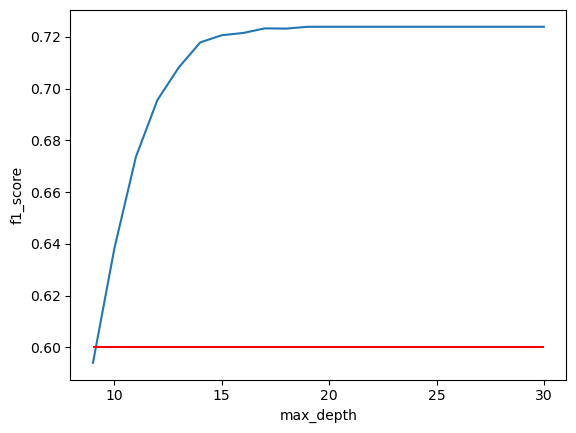

--------f1_score 0.6을 만족하는 최소한의 max_depth--------
max_depth: 10
모델 파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
f1_score: 0.638


In [6]:
model = DecisionTree(pivot_df, embedding)
select_metric = 'f1_score' # 'precision', 'recall', 'f1_score' 중 선택
target_score = 0.6 # 목표 성능 지표
select_param = 'max_depth' # 'max_depth', 'min_samples_split', 'min_impurity_decrease', 'cost_complexity_pruning', 'min_samples_leaf' 중 선택
scale_ls = [i for i in range(30, 5, -1)] # 첫 param 부터 차례로 확인함 --> 순서 조절 주의
fix_params_dic = {'min_samples_leaf':5}

# 해당 target_score보다 낮지 않은 최소한의 parameter를 찾음
proper_param_dic, proper_score = model.get_proper_param(
    target_score=target_score,
    scoring=select_metric,
    check_param=select_param,
    scale_ls=scale_ls,
    **fix_params_dic)
# 1. 완전하게 피팅한 트리를 만듬(= 100점 짜리 트리)
# 2. 완전하게 피팅한 트리에서 해당 파라미터를 추출
# 3. 해당 파라미터를 조금씩 더 엄격하게 조정하면서 트리를 여러번 만듬
# 4. 트리를 만들 때마다 지정한 지표로 성능을 평가
# 5. 지정한 지표가 target_score보다 낮은 경우, 트리를 만드는 것을 중단
# 6. target_score를 만족하는 마지막 parameter를 proper_param로 반환, proper_param에 대한 score를 proper_score로 반환
print(f'--------{select_metric} {target_score}을 만족하는 최소한의 {select_param}--------')
print(f'{select_param}: {proper_param_dic[select_param]}')
print(f'모델 파라미터: {proper_param_dic}')
print(f'{select_metric}: {proper_score:.3f}')

In [11]:
model.max_param_dt = model.make_dt(min_samples_leaf=25, min_impurity_decrease=0.0007) # 최적의 파라미터로 트리 만들기
model.max_param_dt

DecisionTreeClassifier(min_impurity_decrease=0.0007, min_samples_leaf=25,
                       random_state=42)

In [12]:
k=15
len_or_list = []
save_dir = f'../output/{embed_model}_rule'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i in range(k):
    rule_extractor = RuleExtractor(model)
    rules = rule_extractor.extract_rule(segment_num=i)
    
    or_list = rules.split('[OR]')

    ls = [[r.split() for r in l.split('[AND]')] for l in or_list]
    new_ls = []
    for node in ls:
        new_ls.append([])
        rule_dic = {}
        for r in node:
            key_name = f'{r[0]} {r[1]} '
            rule_dic[key_name] = rule_dic.get(key_name, [])
            rule_dic[key_name].append(float(r[2]))    
        
        for k, v in rule_dic.items():
            if k in '>':
                rule_dic[k] = max(v)
            else:
                rule_dic[k] = min(v)
        
        for k, v in rule_dic.items():
            new_rule = k.split()
            new_rule.append(str(v))
            new_ls[-1].append(new_rule)
    
    node_list = []
    for node in new_ls:
        rule_list = []
        for rule in node:
            rule_list.append(''.join(rule))
        node_rule = ' [AND] '.join(rule_list)
        node_list.append(node_rule)
    total_rule = ' [OR]\n'.join(node_list)

    with open(save_dir + f'/{embed_model}_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(total_rule)

In [13]:
rule_dic = {'rule_num':[], 'predict_user_num':[], 'depth_min':[], 'depth_max':[], 'depth_mean':[]}

pred_array = model.max_param_dt.predict(pivot_df)
pred_value_counts = pd.DataFrame(pred_array).value_counts()

k=15
for i in range(k):
    rule_dic['predict_user_num'].append(pred_value_counts[i])
    with open(save_dir + f'/{embed_model}_seg_rule_extract{i}.txt', 'r') as f:
        or_list = f.read().split('[OR]')
    rule_num = len(or_list)
    rule_dic['rule_num'].append(rule_num)
    depth_ls = []
    for and_rule in or_list:
        and_list = and_rule.split('[AND]')
        depth_ls.append(len(and_list))
    rule_dic['depth_max'].append(max(depth_ls))
    rule_dic['depth_min'].append(min(depth_ls))
    rule_dic['depth_mean'].append(np.mean(depth_ls))

rule_stat_df = pd.DataFrame(rule_dic)
rule_stat_df.loc['mean'] = rule_stat_df.mean()
round(rule_stat_df, 2)

,rule_num,predict_user_num,depth_min,depth_max,depth_mean
0,14.0,528.00,6.00,9.00,8.36
1,8.0,490.00,4.00,8.00,5.25
2,1.0,42.00,4.00,4.00,4.00
3,8.0,296.00,5.00,7.00,6.50
4,15.0,584.00,4.00,12.00,7.27
5,2.0,88.00,7.00,7.00,7.00
6,11.0,409.00,6.00,9.00,7.45
7,2.0,79.00,5.00,5.00,5.00
8,6.0,260.00,6.00,9.00,7.83
9,10.0,505.00,6.00,11.00,8.70


In [14]:
rule_stat_df.to_csv('../output/pre_pruning_result.csv', index=False)